In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import mannwhitneyu, chi2_contingency

%matplotlib inline

Import cleaned dataset.

In [2]:
data_dir = os.path.join(os.getcwd(), 'Data')
output_dir = os.path.join(os.getcwd(), 'Figures')

post_peer_review = pd.read_csv(os.path.join(data_dir, 'Peer_Reviewed_Papers_Updated.csv'),
                               index_col=[0, 1], parse_dates=[6, 7])

# Turn this into a category to save memory.
post_peer_review['Decision_Type'] = post_peer_review['Decision_Type'].astype('category')
post_peer_review['Decision_Type'].cat.rename_categories(['Accept', 'Reject', 'Revise'],
                                                        inplace=True)

In [3]:
len(np.unique(post_peer_review.index.get_level_values(0)))

2747

This reproduces Figure 2 in the paper.  

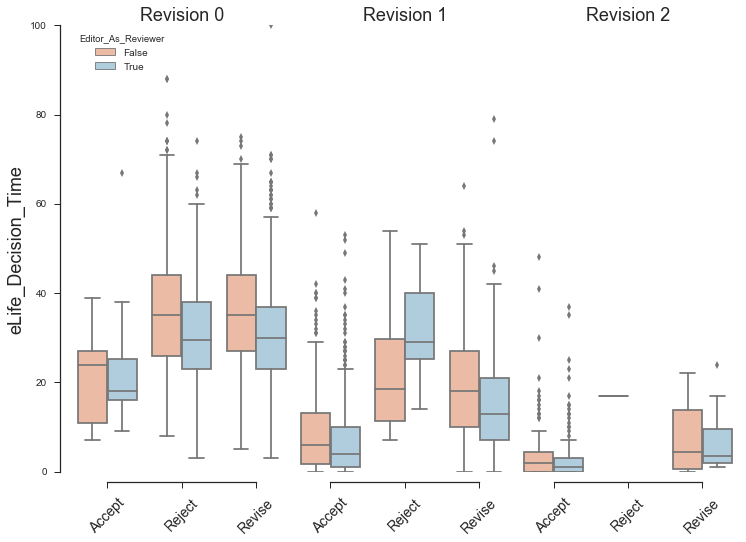

In [4]:
def tweak_xaxis_labels(ax):
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
        tick.set_rotation(45)
    ax.set_xlabel('')
    

fig1 = plt.figure(figsize=(12, 8), dpi=250)
sns.set(style="ticks")

# We do a separate boxplot per each round of revision.
for n_revision in range(3):
    ax = fig1.add_subplot(1, 3, n_revision+1)
    subset = post_peer_review[post_peer_review['Revision Number'] == n_revision]
    sns.boxplot(x='Decision_Type', y="e_Life_Decision_Time", hue="Editor_As_Reviewer",
                data=subset, palette="RdBu", ax=ax)
    ax.set_ylim(0, 100)
    ax.set_title('Revision {}'.format(n_revision), fontsize=18)
    
    # Format the x and y axis across subplots to make the plot look pretty.
    if n_revision == 0:
        sns.despine(ax=ax, offset=10, trim=True)
        tweak_xaxis_labels(ax)
        ax.set_ylabel('eLife_Decision_Time', fontsize=18)
    
    if n_revision == 1:
        sns.despine(ax=ax, left=True, offset=10, trim=True)
        tweak_xaxis_labels(ax)
        ax.yaxis.set_visible(False)
        ax.legend_.remove()
        
    if n_revision == 2:
        sns.despine(ax=ax, left=True, offset=10, trim=True)
        tweak_xaxis_labels(ax)
        ax.yaxis.set_visible(False)
        ax.legend_.remove()
        
fig1.subplots_adjust(wspace=0)
fig1.savefig(os.path.join(output_dir, 'Figure_1.png'),
             dpi=250, bbox_inches='tight')

In [5]:
post_peer_review.ix[3]

,Revision Number,Decision_Type,Editor_As_Reviewer,Manuscript_Number,Received Date,Decision Date,e_Life_Decision_Time,Total_Time,Author_Time
MS TYPE,,,,,,,,,
1,0,Revise,True,3,2012-06-27,2012-07-25,28.0,77.0,6.0
1,1,Accept,True,3,2012-09-05,2012-09-05,0.0,77.0,42.0


Reproduce Table 1 from the main paper.

We look at how the mean e_Life_Decision_Time / Author_Time varies across different rounds of revision as well as in function of having an editor as a reviewer.

We then do a Mann-Whitney test to check if having an editor as a reviewer influences the length of the duration process.  Since we do multiple comparisons, we correct the p-values using [Benjamini-Hochberg](https://en.wikipedia.org/wiki/False_discovery_rate#Benjamini.E2.80.93Hochberg_procedure)

In [6]:
means_elife_time = post_peer_review.pivot_table('e_Life_Decision_Time',
                                                index=['Decision_Type', 'Revision Number'],
                                                columns='Editor_As_Reviewer')
means_author_time = post_peer_review.pivot_table('Author_Time',
                                                 index=['Decision_Type', 'Revision Number'],
                                                 columns='Editor_As_Reviewer')

counts = post_peer_review.pivot_table('e_Life_Decision_Time',
                                      index=['Decision_Type', 'Revision Number'],
                                      columns='Editor_As_Reviewer',
                                      aggfunc='count')
counts.fillna(0, inplace=True)

# Group papers across decision (accept/reject/revise)
# and revision number (0, 1, 2)
gb = post_peer_review.groupby(['Decision_Type', 'Revision Number'])

# We have to write our own function to apply a statistical test
# between the two subgroups
def apply_mw(x, col_name='e_Life_Decision_Time'):
    # Each chunk (x) now refers to a block, grouped by
    # decision_type and by revision number.  We further
    # separate them by which type of editor a paper had.
    re_time = x[x['Editor_As_Reviewer']][col_name].values
    se_time = x[x['Editor_As_Reviewer'] == 0][col_name].values
    
    return mannwhitneyu(re_time, se_time)[1]



# MW for eLife Review Time (between editor reviewer versus
# editor supervisor) stratified across review rounds
# and decision type
mw_elife_time = gb.apply(apply_mw)
# Do multiple testing correction using BH method
_, p_vals, _, _ = multipletests(mw_elife_time, method='fdr_bh')
mw_elife_time.values[:] = p_vals
mw_elife_time.name = 'M-W'

# MW for Author Time (between editor reviewer versus
# editor supervisor) stratified across review rounds
# and decision type
mw_author_time = gb.apply(apply_mw, 'Author_Time')
_, p_vals, _, _ = multipletests(mw_author_time, method='fdr_bh')
mw_author_time.values[:] = p_vals
mw_author_time.name = 'M-W'

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.expand_frame_repr = True
pd.options.display.width = 20

bre_reviewer_effect = pd.concat([counts,
                                 means_elife_time.join(mw_elife_time),
                                 means_author_time.join(mw_author_time)],
                                 axis=1, keys=['counts', 'eLife Time', 'Author Time'])


#bre_reviewer_effect.index.rename(['Revision', 'Decision'], inplace=True)
display(bre_reviewer_effect.fillna('N/A'))

counts  \
Editor_As_Reviewer              False   
Decision_Type Revision Number           
Accept        0                 5.000   
              1               440.000   
              2               115.000   
              3                 6.000   
Reject        0               461.000   
              1                10.000   
              2                 1.000   
              3                 0.000   
Revise        0               705.000   
              1               129.000   
              2                 6.000   
              3                 0.000   

                                       \
Editor_As_Reviewer               True   
Decision_Type Revision Number           
Accept        0                12.000   
              1               650.000   
              2               164.000   
              3                11.000   
Reject        0               616.000   
              1                10.000   
              2                 0.000   
              3                 0.000   
Revise        0               946.000   
              1               182.000   
              2                12.000   
              3                 0.000   

                              eLife Time  \
Editor_As_Reviewer                 False   
Decision_Type Revision Number              
Accept        0                   21.600   
              1                    8.802   
              2                    4.339   
              3                    3.667   
Reject        0                   36.104   
              1                   22.200   
              2                   17.000   
              3                      N/A   
Revise        0                   36.018   
              1                   19.651   
              2                    7.833   
              3                      N/A   

                                      \
Editor_As_Reviewer              True   
Decision_Type Revision Number          
Accept        0               23.333   
              1                6.949   
              2                3.238   
              3                2.455   
Reject        0               30.981   
              1               31.600   
              2                  N/A   
              3                  N/A   
Revise        0               31.053   
              1               15.747   
              2                7.167   
              3                  N/A   

                                     \
Editor_As_Reviewer              M-W   
Decision_Type Revision Number         
Accept        0               0.500   
              1               0.003   
              2               0.088   
              3               0.373   
Reject        0               0.000   
              1               0.074   
              2               0.000   
              3                 N/A   
Revise        0               0.000   
              1               0.003   
              2               0.373   
              3                 N/A   

                              Author Time  \
Editor_As_Reviewer                  False   
Decision_Type Revision Number               
Accept        0                     4.000   
              1                    52.209   
              2                    16.487   
              3                     6.833   
Reject        0                     6.182   
              1                    64.900   
              2                    60.000   
              3                       N/A   
Revise        0                     5.786   
              1                    66.930   
              2                    21.333   
              3                       N/A   

                                       \
Editor_As_Reviewer               True   
Decision_Type Revision Number           
Accept        0                 4.833   
              1                51.168   
              2                14.652   
              3              

Box Plots for Total Time

In [7]:
reviewer_decision_counts = post_peer_review.pivot_table('Manuscript_Number',
                index='Decision_Type', columns='Editor_As_Reviewer', aggfunc='count')
chi2_contingency(reviewer_decision_counts)

(2.1550936592668228,
 0.34042963401173282,
 2,
 array([[  588.00133899,   814.99866101],
        [  460.17496095,   637.82503905],
        [  829.82370007,  1150.17629993]]))

In [8]:
reviewer_decision_counts.index=reviewer_decision_counts.index.tolist()  # Get rid of categorical
reviewer_decision_counts.ix['Totals'] = reviewer_decision_counts.sum(axis=0)
reviewer_decision_counts['Totals'] = reviewer_decision_counts.sum(axis=1)

reviewer_decision_counts

Editor_As_Reviewer,False,True,Totals
Accept,566,837,1403
Reject,472,626,1098
Revise,840,1140,1980
Totals,1878,2603,4481


## Some statistical analysis

In [9]:
first_date = post_peer_review.groupby(level=0).first()[['Received Date', 'Editor_As_Reviewer']]
last_date = post_peer_review.groupby(level=0).last()[['Decision Date', 'Decision_Type']]

final_decision_df = pd.concat([first_date, last_date], axis=1)


final_decision_df['MS_NO'] = final_decision_df.index.get_level_values(0)

# Find first date:
first_pub = final_decision_df['Received Date'].copy()
first_pub.sort_values(inplace=True)
last_pub = first_pub.tail(1).values
first_pub = first_pub.head(1).values

final_decision_df.columns = ['Received_Date', 'Editor_As_Reviewer', 'Decision_Date',
                             'Decision_Type', 'MS_NO']

# NB: Total_Decision_Time differs from Total_Time because it does not include the time
# spent in the pre-review stages.  The difference is minimal 
final_decision_df['Total_Decision_Time'] = (last_date['Decision Date'] - first_date['Received Date']).dt.days
final_decision_df['Received_Since_Start'] =  (first_date['Received Date'] - first_pub).dt.days
final_decision_df['Publication_Since_Start'] =  (last_date['Decision Date'] - first_pub).dt.days
final_decision_df['Received_Date_Str'] = final_decision_df['Received_Date'].apply(lambda x: x.strftime('%d-%m-%Y'))
final_decision_df['Decision_Date_Str'] = final_decision_df['Decision_Date'].apply(lambda x: x.strftime('%d-%m-%Y'))

# Unfortunately, we have to give this pre-processed dataset because giving the unique reviewer
# ids would allow an enterprising researcher to de-anonoymize all editors and reviewers.
unique_reviewers = pd.read_csv(os.path.join(data_dir, 'Unique_Reviewers.csv'), index_col=0,
                               header=None)
final_decision_df['Unique_Reviewers'] = unique_reviewers

for idx in final_decision_df.index:
    final_decision_df.loc[idx, 'Total_Revisions'] = len(post_peer_review.ix[idx])

In [10]:
# drop papers that are still in revision
accept_reject_df = final_decision_df[final_decision_df['Decision_Type'] != 'Revise'].copy()  
accept_reject_df['accept'] = accept_reject_df['Decision_Type'] == 'Accept'

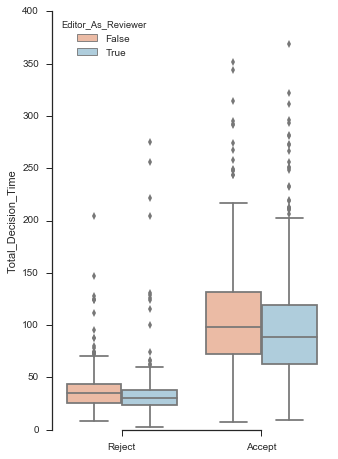

In [11]:
fig = plt.figure(figsize=(5, 7.5), dpi=250)
ax = fig.add_subplot(111)

sns.set(style="ticks")
sns.boxplot(x='Decision_Type', y="Total_Decision_Time", hue="Editor_As_Reviewer",
            data=accept_reject_df, palette="RdBu", ax=ax)
ax.set_ylim((0, 400), emit=True)
ax.set_xlabel('')
sns.despine(trim=True)

fig.savefig(os.path.join(output_dir, 'Figure_2.png'),
            dpi=250, bbox_inches='tight')

### Linear model to see if the BRE_Reviewer still has an effect on the total decision time after taking into account the number of unique reviewers (Table S1)

In [12]:
accept_reject_df['accept'] = accept_reject_df['accept'].astype('int')
formula = 'Total_Decision_Time ~ C(Editor_As_Reviewer) + Unique_Reviewers + C(Decision_Type)'
model = smf.glm(formula=formula, data=accept_reject_df).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     Total_Decision_Time   No. Observations:                 2501
Model:                             GLM   Df Residuals:                     2497
Model Family:                 Gaussian   Df Model:                            3
Link Function:                identity   Scale:                   1618.00877435
Method:                           IRLS   Log-Likelihood:                -12787.
Date:                 Fri, 14 Oct 2016   Deviance:                   4.0402e+06
Time:                         15:25:06   Pearson chi2:                 4.04e+06
No. Iterations:                      4                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                        85.7882      4.461     19.229      0.000        77.044    94.532
C(Editor_As_Reviewer)[T.True]    -9.2276      1.700     -5.428      0.000       -12.560    -5.895
C(Decision_Type)[T.Reject]      -65.3517      1.621    -40.305      0.000       -68.530   -62.174
Unique_Reviewers                  7.1889      1.620      4.438      0.000         4.014    10.364
=================================================================================================
"""

### Logit model to test whether the odds of a paper being accepted are affected by the kind of editor (reviewing versus supervising) and how many days since eLife started accepting papers.  Table S2.

In [13]:
accept_reject_df['accept'] = accept_reject_df['accept'].astype('int')
formula = 'accept ~ C(Editor_As_Reviewer) + Publication_Since_Start + Unique_Reviewers'
model = smf.logit(formula=formula, data=accept_reject_df).fit()
display(model.summary())

Optimization terminated successfully.
         Current function value: 0.684179
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 accept   No. Observations:                 2501
Model:                          Logit   Df Residuals:                     2497
Method:                           MLE   Df Model:                            3
Date:                Fri, 14 Oct 2016   Pseudo R-squ.:                0.002208
Time:                        15:25:06   Log-Likelihood:                -1711.1
converged:                       True   LL-Null:                       -1714.9
                                        LLR p-value:                   0.05573
=================================================================================================
                                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept                         0.6015      0.257      2.344      0.019         0.099     1.105
C(Editor_As_Reviewer)[T.True]     0.0815      0.087      0.939      0.348        -0.089     0.252
Publication_Since_Start          -0.0003      0.000     -2.338      0.019        -0.001 -5.31e-05
Unique_Reviewers                 -0.0386      0.081     -0.474      0.635        -0.198     0.121
=================================================================================================
"""

Logit model to test whether the number of revisions a paper goes through before it is accepted are influenced by the number of days since eLife started accepting papers (the age of the journal) plus the type of reviewer.

In [14]:
formula = 'Total_Revisions ~ Publication_Since_Start + Editor_As_Reviewer + C(Decision_Type) + Unique_Reviewers'
model = smf.glm(formula=formula, data=accept_reject_df, family=sm.families.Poisson()).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Total_Revisions   No. Observations:                 2501
Model:                            GLM   Df Residuals:                     2496
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -3061.5
Date:                Fri, 14 Oct 2016   Deviance:                       141.82
Time:                        15:25:06   Pearson chi2:                     156.
No. Iterations:                     7                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      0.6856      0.099      6.952      0.000         0.492     0.879
Editor_As_Reviewer[T.True]    -0.0134      0.033     -0.403      0.687        -0.078     0.052
C(Decision_Type)[T.Reject]    -0.7762      0.035    -22.225      0.000        -0.845    -0.708
Publication_Since_Start      1.06e-05   5.33e-05      0.199      0.842     -9.39e-05     0.000
Unique_Reviewers               0.0382      0.031      1.230      0.219        -0.023     0.099
==============================================================================================
"""

## Analyze Citation Data

In [15]:
citations_file = os.path.join(data_dir, 'Citations_29-02-2016.csv')
citations_date = os.path.basename(citations_file)[10:-4]
citations_date = pd.to_datetime(citations_date, dayfirst=True)

citations_df = pd.read_csv(citations_file, index_col=0, header=0)
citations_df.index = citations_df.index.values.astype('int')

We look whether the number of citations in SCOPUS is influenced by the kind of reviewer, the days since eLife started publishing papers (age of journal), and the decision time.  Table S4.

In [16]:
accepted_papers = pd.concat([accept_reject_df[accept_reject_df['Decision_Type'] == 'Accept'],
                             citations_df], axis=1)
accepted_papers.dropna(subset=['Received_Date'], inplace=True)
accepted_papers = accepted_papers.rename(columns = {'www.ncbi.nlm.nih.gov': 'Pubmed_Citations',
                                        'www.scopus.com': 'Scopus'})
accepted_papers['Pubmed_Citations'].fillna(0, inplace=True)
accepted_papers['Scopus'].fillna(0, inplace=True)

accepted_papers['Days_Since_Decision'] = citations_date - accept_reject_df['Decision_Date']

accepted_papers['Days_Since_Decision'] = accepted_papers['Days_Since_Decision'].dt.days.astype('int')
accepted_papers['log1p_Citation_Rate'] = np.log1p(accepted_papers['Scopus'] / accepted_papers['Days_Since_Decision'])

formula = 'log1p_Citation_Rate ~ Total_Decision_Time + Editor_As_Reviewer + Unique_Reviewers'
model = smf.glm(formula=formula, data=accepted_papers).fit()
display(model.summary())

accepted_papers_1 = accepted_papers.copy()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     log1p_Citation_Rate   No. Observations:                 1403
Model:                             GLM   Df Residuals:                     1399
Model Family:                 Gaussian   Df Model:                            3
Link Function:                identity   Scale:               9.88133273137e-05
Method:                           IRLS   Log-Likelihood:                 4480.7
Date:                 Fri, 14 Oct 2016   Deviance:                      0.13824
Time:                         15:25:07   Pearson chi2:                    0.138
No. Iterations:                      4                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      0.0038      0.002      2.538      0.011         0.001     0.007
Editor_As_Reviewer[T.True]     0.0025      0.001      4.465      0.000         0.001     0.004
Total_Decision_Time        -2.812e-05   5.27e-06     -5.338      0.000     -3.84e-05 -1.78e-05
Unique_Reviewers               0.0007      0.001      1.241      0.215        -0.000     0.002
==============================================================================================
"""

Using new citation data.

In [17]:
#citations_file = os.path.join(data_dir, 'Citations_29-02-2016.csv')
citations_file = os.path.join(data_dir, 'Citations_10-07-2016.csv')

citations_date = os.path.basename(citations_file)[10:-4]
citations_date = pd.to_datetime(citations_date, dayfirst=True)

citations_df = pd.read_csv(citations_file, index_col=0, header=0)
citations_df.index = citations_df.index.values.astype('int')

In [18]:
accepted_papers = pd.concat([accept_reject_df[accept_reject_df['Decision_Type'] == 'Accept'],
                             citations_df], axis=1)
accepted_papers.dropna(subset=['Received_Date'], inplace=True)
accepted_papers = accepted_papers.rename(columns = {'www.ncbi.nlm.nih.gov': 'Pubmed_Citations',
                                        'www.scopus.com': 'Scopus'})
accepted_papers['Pubmed_Citations'].fillna(0, inplace=True)
accepted_papers['Scopus'].fillna(0, inplace=True)

accepted_papers['Days_Since_Decision'] = citations_date - accept_reject_df['Decision_Date']

accepted_papers['Days_Since_Decision'] = accepted_papers['Days_Since_Decision'].dt.days.astype('int')
accepted_papers['log1p_Citation_Rate'] = np.log1p(accepted_papers['Scopus'] / accepted_papers['Days_Since_Decision'])

formula = 'log1p_Citation_Rate ~ Total_Decision_Time + Editor_As_Reviewer + Unique_Reviewers'
model = smf.glm(formula=formula, data=accepted_papers).fit()
display(model.summary())

accepted_papers_2 = accepted_papers.copy()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     log1p_Citation_Rate   No. Observations:                 1403
Model:                             GLM   Df Residuals:                     1399
Model Family:                 Gaussian   Df Model:                            3
Link Function:                identity   Scale:               0.000195889378811
Method:                           IRLS   Log-Likelihood:                 4000.6
Date:                 Fri, 14 Oct 2016   Deviance:                      0.27405
Time:                         15:25:07   Pearson chi2:                    0.274
No. Iterations:                      4                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      0.0052      0.002      2.448      0.014         0.001     0.009
Editor_As_Reviewer[T.True]     0.0024      0.001      3.059      0.002         0.001     0.004
Total_Decision_Time        -3.081e-05   7.42e-06     -4.155      0.000     -4.54e-05 -1.63e-05
Unique_Reviewers               0.0017      0.001      2.302      0.021         0.000     0.003
==============================================================================================
"""

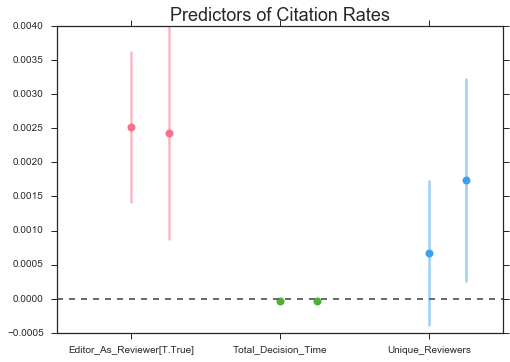

In [21]:
fig3, ax = plt.subplots()

def modified_coefplot(formula, data, ax, jitter=0, intercept=False, ci=95,
                      palette="husl"):
    """Plot the coefficients from a linear model.

    Parameters
    ----------
    formula : string
        patsy formula for ols model
    data : dataframe
        data for the plot; formula terms must appear in columns
    groupby : grouping object, optional
        object to group data with to fit conditional models
    intercept : bool, optional
        if False, strips the intercept term before plotting
    ci : float, optional
        size of confidence intervals
    palette : seaborn color palette, optional
        palette for the horizonal plots

    """
    import statsmodels.formula.api as sf
    import itertools

    alpha = 1 - ci / 100
    coefs = sf.ols(formula, data).fit().params
    cis = sf.ols(formula, data).fit().conf_int(alpha)

    # Possibly ignore the intercept
    if not intercept:
        coefs = coefs.ix[1:]

    n_terms = len(coefs)

    colors = itertools.cycle(sns.color_palette(palette, n_terms))
    for i, term in enumerate(coefs.index):
        color = next(colors)
        low, high = cis.ix[term]
        i += jitter
        ax.plot([i, i], [low, high], c=color,
                solid_capstyle="round", lw=2.5, alpha=0.5)
        ax.plot(i, coefs.ix[term], "o", c=color, ms=8)
    ax.set_xlim(-.5, n_terms - .5)
    ax.axhline(0, ls="--", c="dimgray")
    
    if jitter == 0:
        ax.set_xticks(range(n_terms))
        ax.set_xticklabels(coefs.index)

modified_coefplot(formula, data=accepted_papers_1, ax=ax)
modified_coefplot(formula, data=accepted_papers_2, ax=ax, jitter=0.25)

ax.set_title('Predictors of Citation Rates', fontsize=18)
fig3.savefig(os.path.join(output_dir, 'Figure_3.png'), dpi=125)

Figure 4:

In [22]:
final_decision_df['month'] = final_decision_df['Received_Date'].apply(lambda x: x.month + 12 * ((x.year) - 2012))
papers_by_year_gb = final_decision_df.groupby(['month', 'Editor_As_Reviewer'])
papers_by_year = papers_by_year_gb.apply(lambda x: len(np.unique(x['MS_NO']))).unstack(-1)

papers_by_year['Total'] = papers_by_year.sum(axis=1)
papers_by_year['BRE_Fraction'] = papers_by_year[True] / papers_by_year['Total']

papers_by_year.rename(columns={True: 'Papers_with_RE', False: 'Papers_with_SE'},
                      inplace=True)

# Add information about how many unique editors were active in a given month
n_unique_editors = pd.read_csv(os.path.join(data_dir, 'Unique_Editors_Per_Month.csv'), 
                               index_col=0, header=None)
papers_by_year['Unique_Editors'] = n_unique_editors
papers_by_year['Papers_Per_Editor'] = papers_by_year['Total'] / papers_by_year['Unique_Editors']

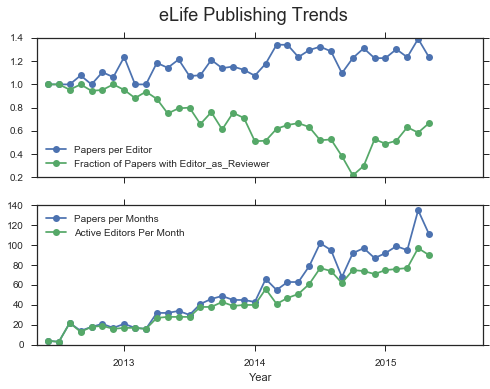

In [23]:
fig4, (ax1, ax2) = plt.subplots(2, sharex=True)

# Drop last months for which we don't have review info yet.
papers_by_year = papers_by_year.ix[:40]

ax1.plot(papers_by_year.index, papers_by_year['Papers_Per_Editor'], marker='o',
        label='Papers per Editor')
ax1.plot(papers_by_year.index, papers_by_year['BRE_Fraction'], marker='o',
        label='Fraction of Papers with Editor_as_Reviewer')
ax1.legend(loc='best')


ax2.plot(papers_by_year.index, papers_by_year['Total'], marker='o',
        label='Papers per Months')
ax2.plot(papers_by_year.index, papers_by_year['Unique_Editors'], marker='o',
        label='Active Editors Per Month')
ax2.legend(loc='best')
ax2.set_xticks([12, 24, 36, 48])
ax2.set_xticklabels([2013, 2014, 2015, 2016])
ax2.set_xlim(4, 45)

ax2.set_xlabel('Year')

fig4.suptitle('eLife Publishing Trends', fontsize=18)
fig4.savefig(os.path.join(output_dir, 'Figure_4.png'), dpi=125)

Let's try some nice data-visualizations now:

In [24]:
import bokeh
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.plotting import ColumnDataSource
from bokeh.models import HoverTool
from bokeh.models.widgets import Panel, Tabs
output_notebook()

Loading BokehJS ...

In [25]:
final_decision_df['Color'] = 'red'
final_decision_df.loc[final_decision_df['Editor_As_Reviewer'] == 1, 'Color'] = 'blue'

for idx in final_decision_df.index:
    final_decision_df.loc[idx, 'Total_Revisions'] = len(post_peer_review.ix[idx])

accepted = final_decision_df[final_decision_df['Decision_Type'] == 'Accept'].copy()
rejected = final_decision_df[final_decision_df['Decision_Type'] == 'Reject'].copy()
revised = final_decision_df[final_decision_df['Decision_Type'] == 'Revise'].copy()

In [26]:
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool, Panel, ColumnDataSource, Tabs

In [27]:
output_notebook()
all_figs = []
for title, df in zip(['Accepted', 'Revised', 'Rejected'],
                     [accepted, revised, rejected]):

    hover = HoverTool(
        tooltips=[
            ("Manuscript Number", "@MS_NO"),
            ("Received Date", "@Received_Date_Str"),
            ("Final Decision Date", "@Decision_Date_Str"),
            ("Total Revisions:", "@Total_Revisions")
        ]
    )
    
    
    data = ColumnDataSource(df)
    p = figure(width=800, height=800, x_axis_type="datetime",
              tools=[hover], title=title)
    p.circle('Received_Date', 'Total_Decision_Time', color='Color', alpha=0.5, 
              source=data)
    
    p.xaxis.axis_label = 'Date Received'
    p.yaxis.axis_label = 'Days Till Decision'
    
    tab = Panel(child=p, title=title)
    all_figs.append(tab)


tabs = Tabs(tabs=all_figs)
show(tabs)

Loading BokehJS ...